Install Tesseract OCR:

On Windows, download and install Tesseract from Tesseract at UB Mannheim. <br>
On macOS, use Homebrew: brew install tesseract. <br>

For Windows, <br>
```bash
https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w64-setup-5.3.3.20231005.exe
```

For Mac, <br>
open terminal and run the following commands:
```bash
# Open Terminal and install Xcode Command Line Tools
xcode-select --install

# Install Homebrew
/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

# Follow the on-screen instructions and then add Homebrew to your PATH
echo 'eval "$(/opt/homebrew/bin/brew shellenv)"' >> /Users/yourusername/.zprofile
eval "$(/opt/homebrew/bin/brew shellenv)"

# Verify the installation
brew doctor

# Update Homebrew
brew update
brew install tesseract
```

In [1]:
!pip install opencv-python scikit-image pytesseract

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 3.2 MB/s eta 0:00:13
   ---------------------------------------- 0.2/38.6 MB 2.5 MB/s eta 0:00:16
    --------------------------------------- 0.5/38.6 MB 4.0 MB/s eta 0:00:10
   - -------------------------------------- 1.1/38.6 MB 6.2 MB/s eta 0:00:07
   -- ------------------------------------- 2.2/38.6 MB 9.3 MB/s eta 0:00:04
   --- ------------------------------------ 3.1/38.6 MB 11.5 MB/s eta 0:00:04
   ---- ----------------------------------- 4.7/38.6 MB 15.0 MB/s eta 0:00:03
   ----- ---------------------------------- 5.1/38.6 MB 14.1 MB/s eta 0:00:03
   ------- -------------------------------- 6.8/38.6 MB 16.2 MB/s eta 0:00:02
   ------- -------------------------------- 7.7/38.6 MB 16.4 MB/s eta 0:00:02
   --------- ------------------------------ 9.6/38.6 MB 18.1 MB/s eta 0:00:02
   ----------- ---------------------------- 11.0/38.6 MB 24.2 MB/s eta 0:00:0

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt,ticker
import pytesseract, shutil 
import csv
from PIL import Image
from skimage.measure import label, regionprops

## Step 1: Load Image

In [4]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [6]:
# Load the image
im_path = 'XRD.png'
# r'C:\Users\user\Download\XRD.png'jk
image = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
print('Original Dimensions : ',image.shape)
image = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
print('Grayscale Dimensions : ',image.shape)
print(image)
# 255 white; 0 black

Original Dimensions :  (1094, 1770, 4)
Grayscale Dimensions :  (1094, 1770)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


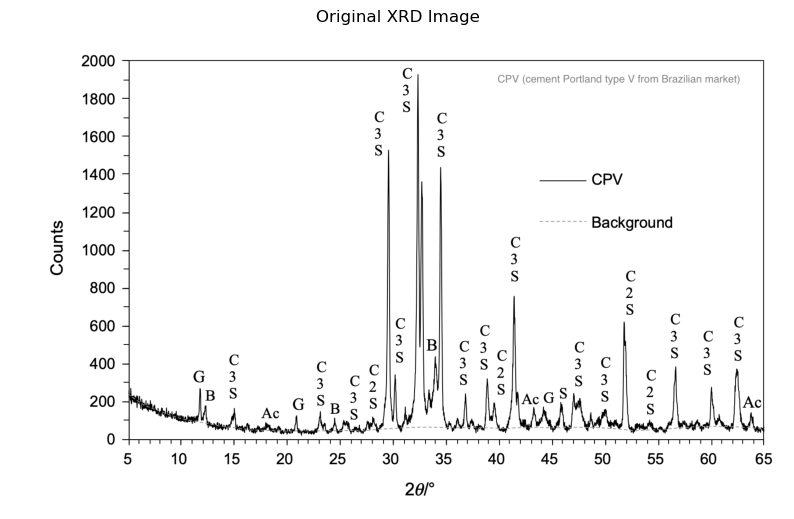

In [7]:
# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.title('Original XRD Image')
plt.axis('off')
plt.show()

In [8]:
# Obtain image size
height, width = image.shape

## Step 2: Extract text with tesseract OCR

In [9]:
# Configuring Tesseract
# --oem 3: Use the LSTM OCR Engine only.
# --psm 6: Assume a single uniform block of text.
# -c tessedit_char_whitelist=0123456789: Limit recognition to digits only.
config = '--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
data = pytesseract.image_to_data(image, config=config, output_type='dict')
data['text'] = [i for i in data['text'] if i.strip() != '']
print(data['text'])

['2000', '1800', '5', '1600', '3', '3', '1400', '2', '1200', '8', '1000', '3', '800', '5', '600', '3', '33', '400', '35', '3', '3', '35', '81', '5', '3', '5', '200', '3', '3', '0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '26']


In [10]:
# Let's run a test
# Define a function to get the positon of a target string
def get_position(data, target_string):
    target_index = next((i for i, text in enumerate(data['text']) if target_string in text), None)
    if target_index is not None:
        x, y, w, h = data['left'][target_index], data['top'][target_index], data['width'][target_index], data['height'][target_index]
        print(f"Position of '{target_string}': (x={x}, y={y}), width={w}, height={h}")
        return w, h
    else:
        print(f"'{target_string}' not found in the text.")
    

In [11]:
w_10, h_10 = get_position(data, '10')
w_20, h_20 = get_position(data, '20')
each_width = (w_20 - w_10)

Position of '10': (x=833, y=226), width=14, height=24
Position of '20': (x=0, y=0), width=1770, height=1094


In [13]:
w_8, h_8 = get_position(data, '600')

Position of '600': (x=164, y=59), width=75, height=26


## Step 3: Remove borders

In [15]:
# Crop image by border
image =  cv2.imread('XRD.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 這樣就可以保留有顔色 和gray的圖案
# Notice that cvtColor with cv2.COLOR_BGR2GRAY keeps the original image unchanged
print('image dimensions:', image.shape)
print('gray dimensions:', gray.shape)

image dimensions: (1094, 1770, 3)
gray dimensions: (1094, 1770)


In [17]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)
print('Unique values in the gray image:', np.unique(gray))
print('Unique values in the thresholded image:', np.unique(thresh))

Unique values in the gray image: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 2

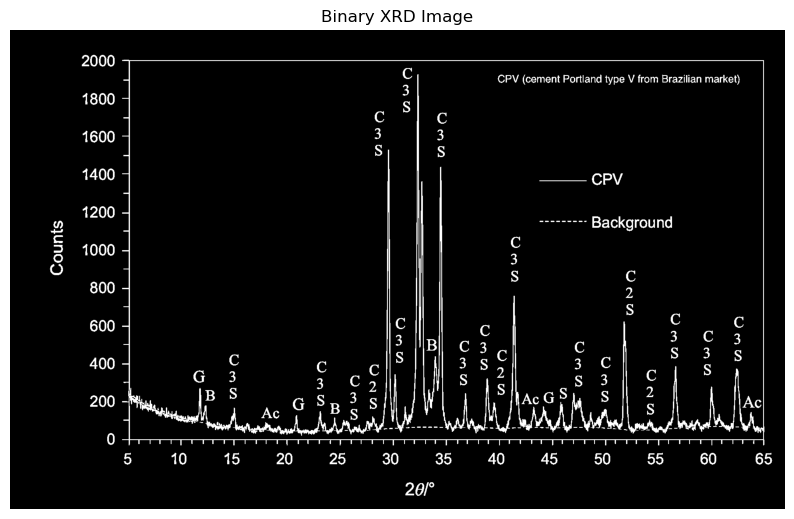

In [12]:
# Display the Binary image
plt.figure(figsize=(10, 8))
plt.imshow(thresh, cmap='gray')
plt.title('Binary XRD Image')
plt.axis('off')
plt.show()

In [20]:
# Contour Detection and Filling
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
print('Found {} contours'.format(len(cnts)))
print('Each contour is described as a list of points:', cnts[0][:5])

Found 73 contours
Each contour is described as a list of points: [[[ 936 1035]]

 [[ 935 1036]]

 [[ 934 1036]]

 [[ 930 1040]]

 [[ 930 1041]]]


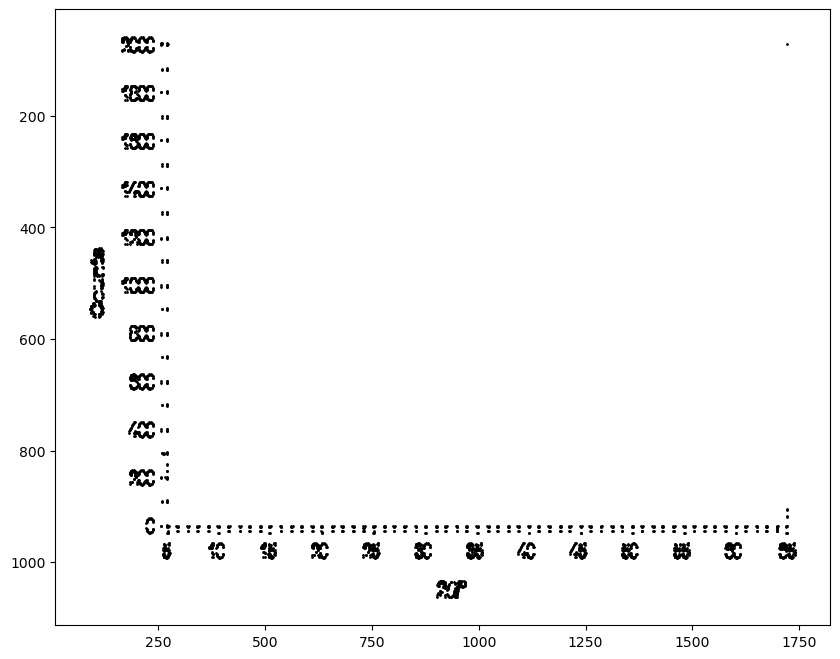

In [21]:
# Display the contours
fig, ax = plt.subplots(figsize=(10, 8))
for i, c in enumerate(cnts):
    ax.scatter(c[:, 0, 0], c[:, 0, 1], s=1, c='k')
ax.invert_yaxis()
plt.show()

In [22]:
# Let's fill the contours by white color
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (255, 255, 255), -1)

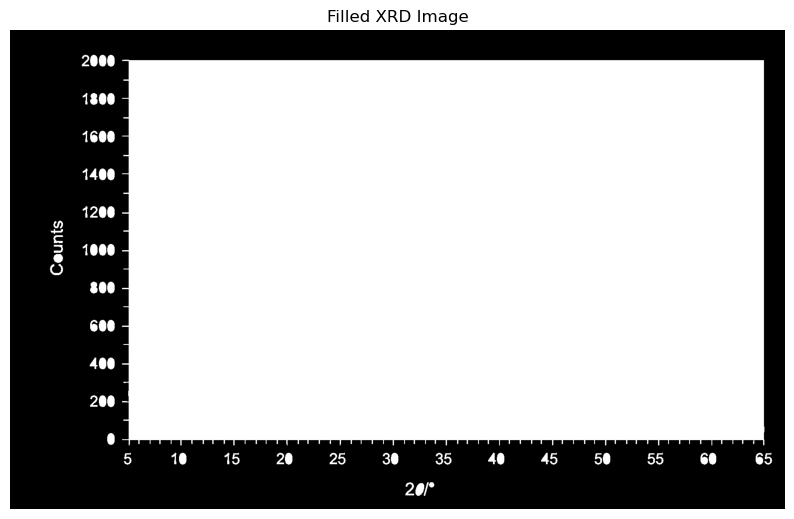

In [23]:
# Display the Filled image
plt.figure(figsize=(10, 8))
plt.imshow(thresh, cmap='gray')
plt.title('Filled XRD Image')
plt.axis('off')
plt.show()

In [24]:
# Morphological Operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)
# 大方框是主體，其他字對於他來説是noise

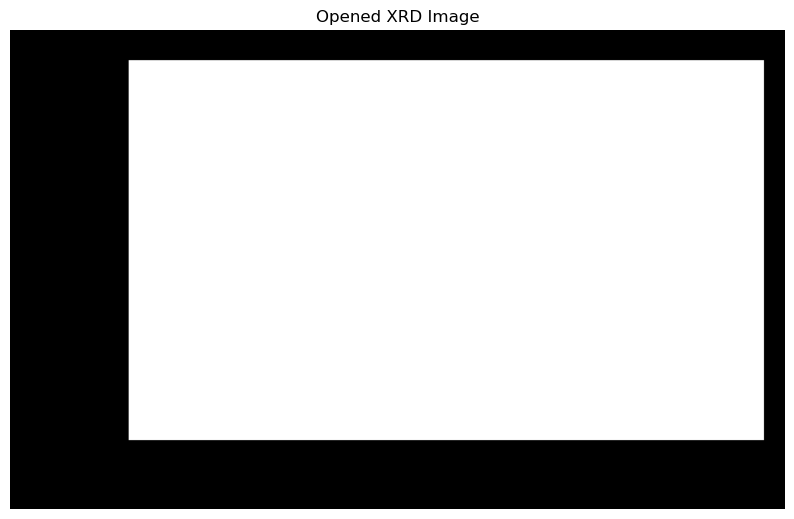

In [25]:
# Display the Open image
plt.figure(figsize=(10, 8))
plt.imshow(opening, cmap='gray')
plt.title('Opened XRD Image')
plt.axis('off')
plt.show()

In [38]:
# Contour Detection with Area Thresholding
# Cut out the spectrum
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
area_treshold = 4000
for c in cnts: #那72個contour
    if cv2.contourArea(c) > area_treshold :
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
        roi = image[y:y+h, x:x+w]

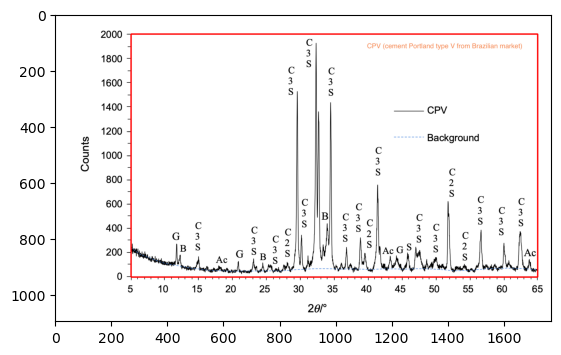

In [33]:
cnts[0]
cv2.contourArea(cnts[0])
cv2.boundingRect(cnts[0])
img=cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 3)
plt.imshow(img)

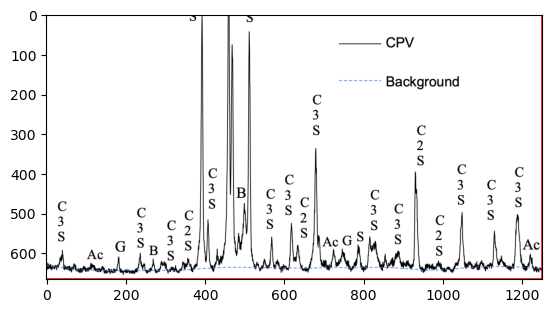

In [37]:
roi = image[y+200:y+h, x+200:x+w]
plt.imshow(roi)

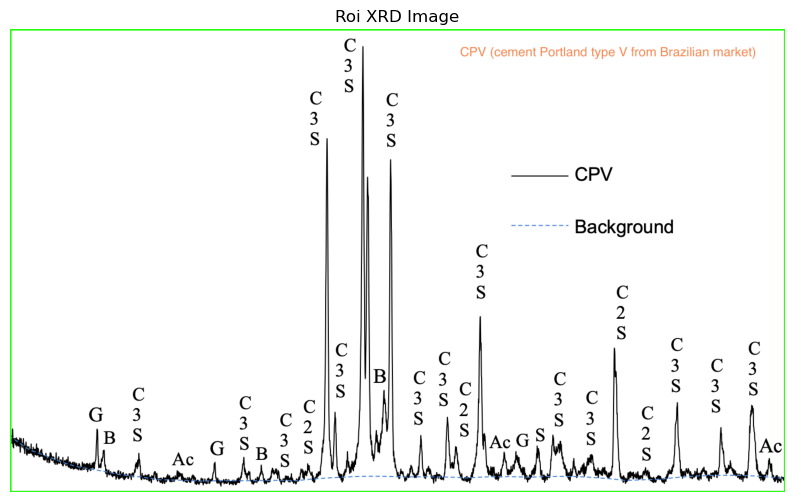

In [39]:
# Display the ROI image
plt.figure(figsize=(10, 8))
plt.imshow(roi, cmap='gray')
plt.title('Roi XRD Image')
plt.axis('off')
plt.show()

## Step 4: Mask the text on the image

In [52]:
# Blurring
img = roi.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (21, 21), 0)

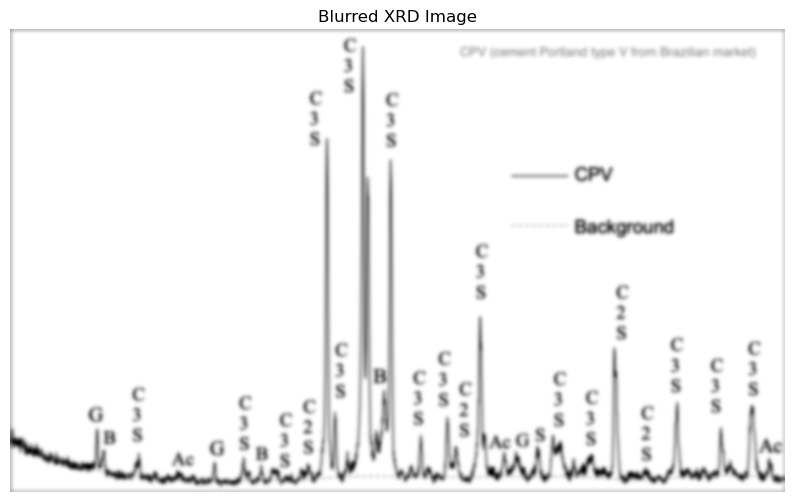

In [53]:
# Display the Blurred image
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.title('Blurred XRD Image')
plt.axis('off')
plt.show()

In [54]:
# Detect the texts with Tesseract again
config = '--oem 3 --psm 6'
data = pytesseract.image_to_data(img, config=config, output_type='dict')
boxes = len(data['level'])
print(data['text'])

['', '', '', '', '¢', 'et', 'Ota', 'Yee', 'he', 'arte', 'eee', '', '’', '', 'c', 'c', '', '’', '’', '', 's', 's', '', '——', 'CPV', '', 'Background', '', 'c', '', '’', '', 's', 'c', '', '2', '', 's', '', 'c', 'c', 'c', 'c', '', '3', '5', '€c', '3', '', 'c', 'c', '¢', 'ss', 'sc', 's', '', 'G3', '»', '¢3', '$3', 'sai', '', 'a', '5', '’', 'os,', '§', '', 'ne', 'O', 'Sag', 's']


In [55]:
# Masking the text
image_masked = roi.copy()
for i in range(boxes):
    if data['text'][i] != ' ' and data['text'][i] != '':
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        mask2 = np.zeros_like(image_masked)
        cv2.rectangle(mask2, (x,y), (x+w,y+h), (255, 255, 255), -1)  # (255,255,255)是mask白色
        image_masked = cv2.bitwise_or(image_masked, mask2)

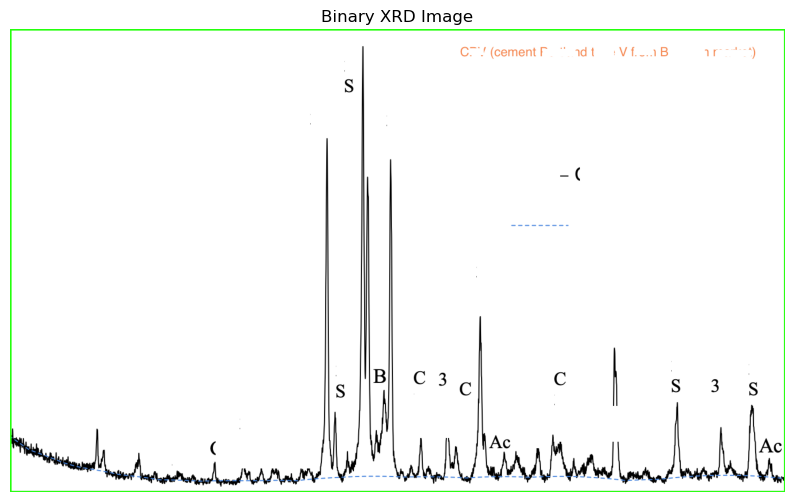

In [56]:
# Display the Masked image
plt.figure(figsize=(10, 8))
plt.imshow(image_masked, cmap='gray')
plt.title('Binary XRD Image')
plt.axis('off')
plt.show()

In [49]:
# Masking the text
image_masked = roi.copy()
for i in range(boxes):
    if data['text'][i] != ' ' and data['text'][i] != '':
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        mask2 = np.zeros_like(image_masked)
        cv2.rectangle(mask2, (x,y), (x+w,y+h), (255, 255, 255), -1)
        image_masked = cv2.bitwise_or(image_masked, mask2)

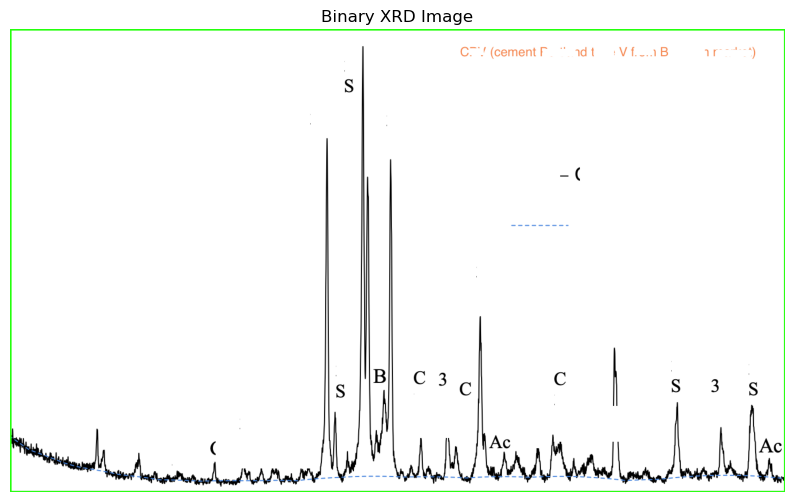

In [57]:
# Display the Masked image
plt.figure(figsize=(10, 8))
plt.imshow(image_masked, cmap='gray')
plt.title('Binary XRD Image')
plt.axis('off')
plt.show()

In [58]:
# Detect again with a different configuration
config = '--oem 3 --psm 3'
data = pytesseract.image_to_data(img, config=config, output_type='dict')
boxes = len(data['level'])
print(data['text'])
for i in range(boxes):
    if data['text'][i] != ' ' and data['text'][i] != '':
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        mask2 = np.zeros_like(image_masked)
        cv2.rectangle(mask2, (x,y), (x+w,y+h), (255, 255, 255), -1)
        image_masked = cv2.bitwise_or(image_masked, mask2)

['', '', '', '', '—-', '', '', '', 'so', 'Perce', '', '', '', 'et!', 'ew', 'me', '', '', '', 'v', '', '', '', 'Vee', '', '', '', 'Vee', '', '', '', 'Vee', '', '', '', 'Vee', '', 'Vee', '', '', '', 'Veo', '', 'vVaw', '', '', '', 'vVawew', '', '', '', 'Vee', '', 'Vee', '', '', '', 'vVaew', '', 'Vee', '', 'Vee']


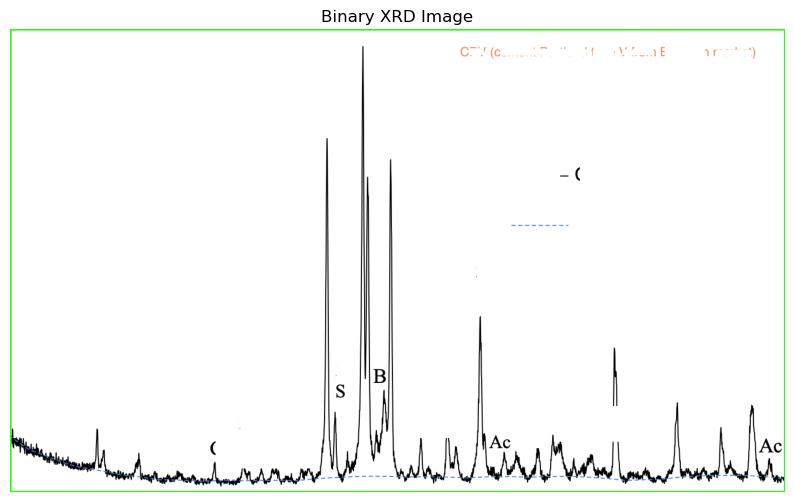

In [60]:
# Display the Masked image
plt.figure(figsize=(10, 8))
plt.imshow(image_masked)
plt.title('Binary XRD Image')
plt.axis('off')
plt.show()

## Step 5: Rescale the image and plot

['', '', '', '', '2000', '', '', '', '13800', '', '', '', '5', '', '', '', '1600', '', '', '', '5', '', '', '', '5', '', '', '', '1400', '', '', '', '1200', '', '', '', '1000', '', '', '', '5', '', '', '', '300', '', '', '', '5', '', '', '', '600', '', '', '', '5', '', '', '', '5', '', '', '', '5', '', '', '', '4007', '', '', '', '5', '', '', '', '7', '2', '', '', '', '2', '', '', '', '200', '', '', '', '7', '', '', '', '7', '', '', '', '0', '', '', '', '171', '', '', '', '10', '', '', '', '15', '', '', '', '20', '', '', '', '20', '', '', '', '30', '', '', '', '39', '', '', '', '40', '', '', '', '45', '', '', '', '50', '', '', '', '60', '', '', '', '65', '', '', '', '20']
[['10', 370, 967], ['15', 491, 967], ['20', 609, 967], ['20', 730, 967], ['30', 852, 967], ['39', 973, 967], ['40', 1093, 967], ['45', 1214, 967], ['50', 1336, 967], ['60', 1578, 967], ['65', 1704, 967]]


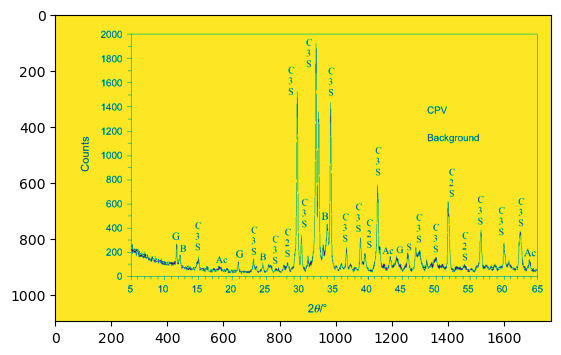

In [62]:
min_edge = 0.1
min_fill = 0 
t = 0.9
image = cv2.imread('XRD.png')
image = image[..., ::-1] 
image = image[:, :, :3]
images = []
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = (gray > t).astype(np.uint8)
plt.imshow(binary)
#######detect the max and min value of x-y axis#########
config = '--oem 3 --psm 11 -c tessedit_char_whitelist=0123456789'
data = pytesseract.image_to_data(binary, config=config, output_type='dict')
print(data['text'])
boxes = len(data['level'])
text_position = []
for i in range(boxes):
    if data['text'][i] != ' ' and data['text'][i] != '':
        x = data['left'][i]
        y = data['top'][i]
        text_position.append([data['text'][i],x,y])
max_y = 1
max_x = max(text_position, key=lambda x: x[1])
# y_right = max_y[1]+60
# y_left = (max_y[1])-60
result_list = [sublist for sublist in text_position if sublist[2] == max_x[2]]
min_x = min(result_list, key=lambda x: x[1])
print(result_list)
#result_list = [sublist for sublist in text_position if sublist[1] <= y_right and sublist[1] >= y_left]
min_y = 0

# print(min_x)

In [63]:
max_x = max(text_position, key=lambda x: x[1])
print(max_x)
min_x = min(result_list, key=lambda x: x[1])
print(min_x)

['65', 1704, 967]
['10', 370, 967]


866 1451
397
396
396
395
396
396
398
399
399
406
408
409
409
410
412
413
414
416
417
418
418
417
416
415
412
411
409
409
407
405
400
399
399
420
419
417
419
420
423
363
362
358
363
329
332
404
403
402
403
404
410
405
404
313
314
315
319
316
315
1003
1003
1002
1002
1001
1002
1002
1003
277
494
493
493
500
500
498
316
318
301
301
303
302
301
302
307
1218
577
291
290
288
288
293
294
292
291
290
290
289
285
284
283
282
281
279
279
280
283
284
283
282
279
282
283
282
280
279
279
280
282
284
290
290
292
293
294
294
295
289
288
289
290
291
292
293
294
293
292
249
250
253
254
256
255
254
250
1407
1407
1131
1131
1135
1136
1138
1139
1138
1138
1135
1134
864
864
862
862
861
860
859
859
860
859
859
862
862
863
863
865
852
853
856
857
856
853
568
569
569
570
1371
1371
1369
837
838
843
845
845
846
847
848
852
853
854
855
856
857
857
855
852
851
849
848
847
844
844
839
838
811
1234
1239
1240
1238
1233
1239
1240
1241
1240
1241
1106
1106
1113
1113
1112
1111
1096
1098
728
585
584
581
582
581
590
583
582
5

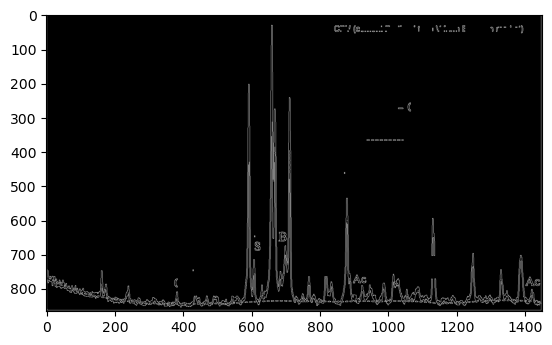

In [64]:
img = image_masked
height = img.shape[0]
width = img.shape[1]
print(height,width)
blurred = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
edged = cv2.Canny(blurred, 30, 150)
plt.imshow(edged, cmap='gray')
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x = []
y = []
for contour in contours:
    for i in range(len(contour)):
        x_value = (contour[i][0][0])
        print(contour[i][0][0])
        x_value = x_value/width*(int(max_x[0])-int(min_x[0]))+10
        x.append(x_value)
        y_value = height
        y_value = contour[i][0][1]
        
        y_value = height - y_value
        y_value = y_value/height*(int(max_y)-int(min_y))
        y.append((y_value))
cv2.imwrite('output1.png', edged )
data = list(zip(x,y))
csv_file = 'output.csv'
header = ['x', 'y']
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(data)

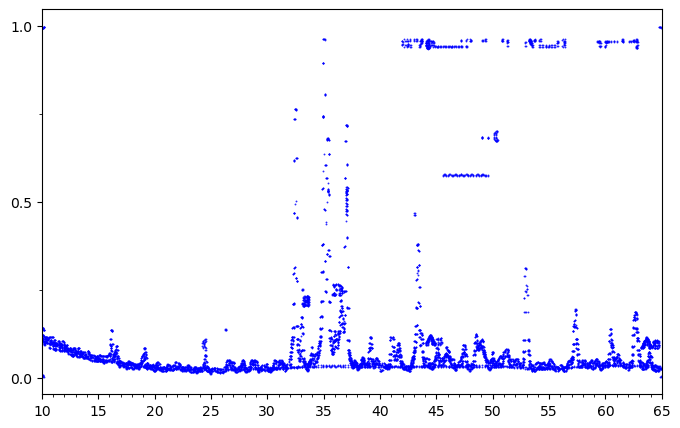

In [65]:
df = pd.read_csv('output.csv')
x = df['x']
y = df['y']
fig, ax = plt.subplots(figsize=(8,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
xmajor, xminor = 5, 1
ymajor, yminor = 0.5,0.25
ax.xaxis.set_major_locator(ticker.MultipleLocator(xmajor))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(xminor))
ax.yaxis.set_major_locator(ticker.MultipleLocator(ymajor))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(yminor))
#ax.set_xlim(5,10)
ax.set_xlim(int(min_x[0]),int(max_x[0]))
#ax.set_ylim(0,20)
plt.scatter(x,y,c = "b",s = 0.1,alpha = .8,marker = "D")
plt.show()
